In [2]:
import pandas as pd
from pandas import option_context
import glob
import sys
from sklearn.model_selection import train_test_split
import numpy as np
sys.path.append('..\Scripts')
import helperfn as hf

%load_ext autoreload
%autoreload 2

## Testing the performance on Tweets dataset
Using the same pipeline (set of methods as used in the web application backend)

### Getting Tweets that were collected into a csv file by evaluators 

In [3]:
tweets_eva = hf.merge_datasets(r'E:\GitHubProjects\dissertation\scraper\tweets_dataset')
tweets_eva['sentiment'] = tweets_eva['sentiment'].str.replace('Negative', '0')
tweets_eva['sentiment'] = tweets_eva['sentiment'].str.replace('Positive', '1')
tweets_eva

,review,sentiment
0,Less than 20% of my students had ever read MLK...,1
1,I'm very pleased to announce that my Teaching ...,1
2,I studied with Diana for 2 years of science of...,1
3,The elected President and VP Academic Experien...,1
4,I studied with Angelia for 7 months of economi...,1
...,...,...
305,Never forget that the University of Glasgow re...,0
306,if you're not a student at glasgow uni and you...,1
307,Seizing Women in STEM Scholarship 2021 in the ...,1
308,#resignsarahsmith All these pro independence ...,0


### Loading tokenizer and ml model and pre-processing algorithms copied over from backend

In [28]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle as pk

# load ML model
model = load_model('NgramLemma.h5')
# load tokenizer
with open("tokenizer_lemmatization.pickle", 'rb') as handle:
    tokenizer = pk.load(handle)
print("ML Model Loaded")

from nltk.tokenize import RegexpTokenizer
import re
import sys 
sys.path.append('..\..\Scripts')
import helperfn as hf

stop = hf.stop_words()
uni_names = hf.uni_names()

def getSentiment(tweets):
    tweets_sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(tweets_sequences, maxlen=137)
    sentiment = model.predict(padded).flatten().tolist()
    return sentiment

def cleanTweets(tweets):
    tweets = hf.remove_mentions(tweets)

    tokenizer = RegexpTokenizer(r'([\w\']+|\[+|]+|\!+|"+|\$+|%+|&+|\'+|\(+|\)+|\*+|\++|,+|\.+|:+|;+|=+|#+|@+|\?+|\[+|\^+|_+|`+|{+|\|+|\}+|~+|-+|]+)') 

    tweets = [tokenizer.tokenize(x) for x in tweets]

    # lower case
    tweets = [hf.lower_token(x) for x in tweets]

    # remove stop words
    tweets = [hf.remove_stopwords(x) for x in tweets]

    # remove university names as they impact accuracy, these words should be neutral sentiment 
    tweets = [hf.remove_uni_names(x) for x in tweets]

    # #reduce puncuations, remove duplicates next to each other and leave only one e.g. !!! to !
    tweets = [hf.remove_punctuations(x) for x in tweets]

    # lemmatization
    tweets = [hf.lemmatization(x) for x in tweets]
    return tweets

def cleanSingle(text):
    # remove @ mentions or URL links
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)

    tokenizer = RegexpTokenizer(r'([\w\']+|\[+|]+|\!+|"+|\$+|%+|&+|\'+|\(+|\)+|\*+|\++|,+|\.+|:+|;+|=+|#+|@+|\?+|\[+|\^+|_+|`+|{+|\|+|\}+|~+|-+|]+)') 

    text = tokenizer.tokenize(text)

    # lower case
    text = hf.lower_token(text)

    # remove stop words
    text = [item for item in text if item not in stop]

    # remove university names as they impact accuracy, these words should be neutral sentiment 
    text = [item for item in text if item not in uni_names]

    # reduce puncuations, remove duplicates next to each other and leave only one e.g. !!! to !
    text = hf.remove_punctuations(text)

    #lemmatization
    text = hf.lemmatization(text)
    return text


from nltk.tokenize import sent_tokenize, word_tokenize
def sentimentSentence(tweets):
    allTweets = []
    for tweet in tweets:
        sentences = sent_tokenize(tweet) 
        sentencesClean = [cleanSingle(sentence) for sentence in sentences]    
        tweetSentiment = getSentiment(sentencesClean)
        singleTweet = [{"tweet": [{"sentence": sentences[i], "sentiment": tweetSentiment[i]} for i in range(len(sentences))]}]
        allTweets.append(singleTweet)

    return allTweets

def sentimentToString(pred):
    rounded = round(pred)
    if rounded == 0:
        return "Negative"
    else:
        return "Positive"

ML Model Loaded


### Running evaluation and getting results

Accuracy:  0.7548387096774194
Precision:  0.7219512195121951
Recall:  0.8862275449101796
F1-score:  0.7956989247311828


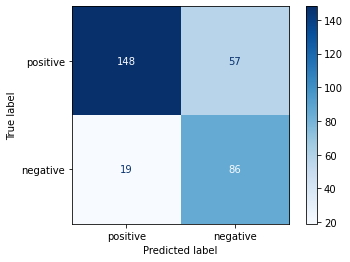

In [29]:
from sklearn.metrics import confusion_matrix
import graphs as gh

tweets = tweets_eva['review'].tolist()
y_test = np.array(tweets_eva['sentiment'].tolist())
y_test = y_test.astype(int)

#PREDICT EACH TWEET VERSION
# cleaned = cleanTweets(tweets) 
# y_pred = getSentiment(cleaned)

#PREDICT EACH SENTENCE VERSION
y_pred = []
for tweet in tweets:
    sentences = sent_tokenize(tweet) 
    sentencesClean = [cleanSingle(sentence) for sentence in sentences]    
    tweetSentiment = getSentiment(sentencesClean)

    #get mean of sentences sentiment
    y_pred.append(np.mean(tweetSentiment))
  
y_pred = np.array(y_pred)
y_pred = np.where(y_pred > 0.5, 1, 0)

# # y_pred = (model.predict(cleaned).ravel()>0.5)+0 # predict and get class (0 if pred < 0.5 else 1)
tp, fp, fn, tn = confusion_matrix(y_test, y_pred, labels=[1, 0]).ravel()
conf = confusion_matrix(y_test, y_pred, labels=[1, 0])
gh.conf_matrix(conf)

accuracy = (tp+tn) / (tp+tn+fp+fn) 
precision = tp / (tp+fp)
recall = tp / (tp+fn)
print("Accuracy: ", (tp+tn) / (tp+tn+fp+fn))
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", (2*precision*recall) / (precision+recall))

Hardcoded graph used in report for evaluating models on tweets

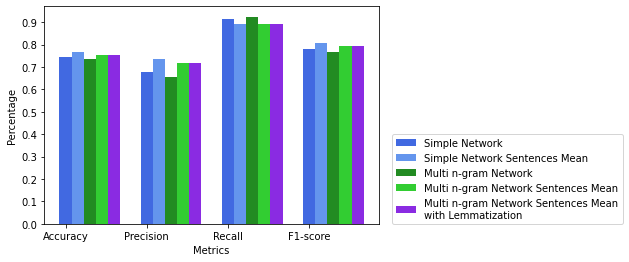

In [33]:
import matplotlib.pyplot as plt
bar_labels = ["Accuracy", "Precision", "Recall", "F1-score"]
dataSimple = [0.7451612903225806, 0.6780487804878049, 0.9144736842105263, 0.7787114845938375]
dataNgram = [0.7354838709677419, 0.6536585365853659, 0.9241379310344827, 0.7657142857142857]
dataSimpleMean = [0.7677419354838709, 0.7365853658536585, 0.893491124260355, 0.8074866310160428]
dataNgramMean = [0.7548387096774194, 0.7170731707317073, 0.8909090909090909, 0.7945945945945946]

dataNgramMeanLemma = [0.7548387096774194, 0.7219512195121951, 0.8862275449101796, 0.7956989247311828]
width = 0.15
plt.bar(np.arange(len(dataSimple)), dataSimple, width=width, label="Simple Network", color="royalblue")
plt.bar(np.arange(len(dataSimpleMean)) + width, dataSimpleMean, width=width, label="Simple Network Sentences Mean",color="cornflowerblue")
plt.bar(np.arange(len(dataNgram))+ width*2, dataNgram, width=width, label="Multi n-gram Network", color="forestgreen")
plt.bar(np.arange(len(dataNgramMean))+ width*3, dataNgramMean, width=width, label="Multi n-gram Network Sentences Mean", color="limegreen")
plt.bar(np.arange(len(dataNgramMeanLemma))+ width*4, dataNgramMean, width=width, label="Multi n-gram Network Sentences Mean\nwith Lemmatization", color="blueviolet")
# plt.title('Performance metrics of Networks Evaluated on Tweets')
plt.xticks([0,1,2,3], bar_labels)
plt.yticks(np.arange(0, 1, 0.10))
plt.ylabel('Percentage')
plt.xlabel('Metrics')
plt.legend(loc=(1.04,0))
plt.show()

## Old hardcoded graph for comparing networks on tweets

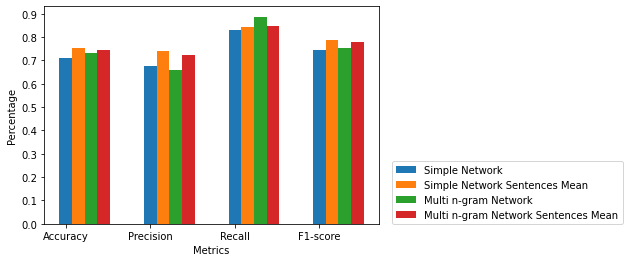

In [23]:
import matplotlib.pyplot as plt
bar_labels = ["Accuracy", "Precision", "Recall", "F1-score"]
dataSimple = [0.7109826589595376, 0.6759259259259259, 0.8295454545454546, 0.7448979591836735]
dataNgram = [0.7341040462427746, 0.6574074074074074, 0.8875, 0.7553191489361702]
dataSimpleMean = [0.7514450867052023, 0.7407407407407407, 0.8421052631578947, 0.7881773399014779]
dataNgramMean = [0.7456647398843931, 0.7222222222222222, 0.8478260869565217, 0.78]
width = 0.15
plt.bar(np.arange(len(dataSimple)), dataSimple, width=width, label="Simple Network")
plt.bar(np.arange(len(dataSimpleMean)) + width, dataSimpleMean, width=width, label="Simple Network Sentences Mean")
plt.bar(np.arange(len(dataNgram))+ width*2, dataNgram, width=width, label="Multi n-gram Network")
plt.bar(np.arange(len(dataNgramMean))+ width*3, dataNgramMean, width=width, label="Multi n-gram Network Sentences Mean")
# plt.title('Performance metrics of Networks Evaluated on Tweets')
plt.xticks([0,1,2,3], bar_labels)
plt.yticks(np.arange(0, 1, 0.10))
plt.ylabel('Percentage')
plt.xlabel('Metrics')
plt.legend(loc=(1.04,0))
plt.show()